<a href="https://colab.research.google.com/github/mlbrilliance/Federated_Q_Learning_Maze_Simulation/blob/main/Federated_Q_Learning_Maze_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Q-Learning Maze Simulation

## Developer
Nick Sudh

https://mlbrilliance.com/

This repository contains a simulation of a federated Q-learning algorithm applied to a maze environment. The simulation demonstrates how multiple agents can explore a maze, learn locally via Q-learning, and then periodically share (average) their Q-tables to improve learning through federated communication.

## Features

The simulation includes the following key features:

- **Maze Environment:** A 5×5 grid maze where:
  - `0` denotes a free cell
  - `1` denotes a wall
  - The starting cell is at (0, 0) and the goal (treasure) is at (4, 4)

- **Multiple Agents:** Five agents navigate the maze using an epsilon‑greedy Q-learning policy

- **Federated Learning:** After every fixed number of episodes (communication round), agents average their local Q-tables to form a global Q-table

- **Animation:** Real-time animation of the agents moving through the maze using `matplotlib`

## Requirements

The simulation requires:

- Python 3.6+
- `numpy`
- `matplotlib`

Install the required dependencies using pip:

```bash
pip install numpy matplotlib
```

## How to Run

You can run the simulation in two different ways:

### Running as a Python Script

1. Save the code below in a file named `federated_maze.py`
2. Open a terminal and run:
   ```bash
   python federated_maze.py
   ```
3. Ensure that your Python environment supports interactive plotting

### Running in a Jupyter Notebook

1. Create a new notebook
2. Paste the code (provided below) into a cell
3. Run the cell with one of these magic commands:
   ```python
   %matplotlib notebook
   ```
   or
   ```python
   %matplotlib qt
   ```

## Code Explanation

The simulation consists of several key components:

### Maze Environment Definition
- The maze is defined as a 5×5 grid
- The `maze_step` function computes the next state given an action, handling walls and boundaries
- Each move incurs a penalty of -1
- Reaching the goal yields +10

### Federated Q-Learning Setup
- Each of the 5 agents maintains its own local Q-table
- Q-tables are 3D arrays with dimensions `[rows, cols, num_actions]`
- During each episode, agents update their Q-values using Q-learning
- Every `comm_interval` episodes, agents average their Q-tables (simulating a communication round)

### Visualization
- The maze is visualized using `imshow`
- Each agent is represented by a colored marker
- Agent positions are updated after every step
- Canvas updates are forced using:
  - `fig.canvas.draw_idle()`
  - `fig.canvas.flush_events()`

### Testing
After training completes:
- The global Q-table is used to compute the optimal path
- The optimal path from start to goal is printed

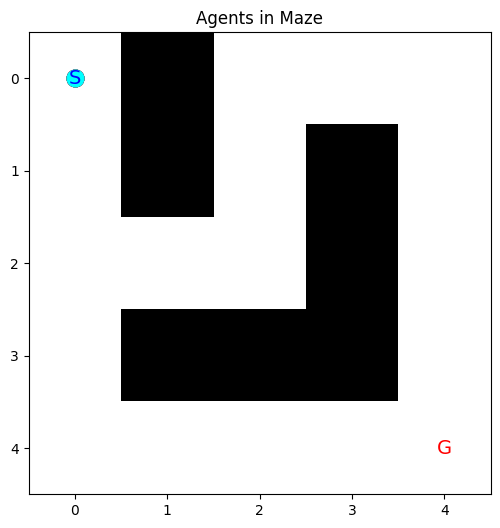

Episode 1, Agent 1 path: [(0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (2, 0), (1, 0), (1, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (2, 0), (2, 0), (2, 1), (2, 1), (2, 1), (2, 0), (1, 0), (1, 0), (1, 0), (2, 0), (3, 0), (4, 0), (3, 0), (3, 0), (3, 0), (2, 0), (2, 0), (2, 1), (2, 0), (3, 0), (4, 0), (4, 0), (4, 0), (4, 1), (4, 1), (4, 1), (4, 0), (3, 0), (3, 0), (3, 0), (4, 0), (4, 0), (4, 0), (4, 1), (4, 2), (4, 2), (4, 2), (4, 1), (4, 1), (4, 1), (4, 2), (4, 3), (4, 3), (4, 3), (4, 2), (4, 2), (4, 2), (4, 3), (4, 4)]
Episode 1, Agent 2 path: [(0, 0), (0, 0), (1, 0), (2, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (2, 0), (3, 0), (2, 0), (2, 0), (2, 1), (2, 2), (1, 2), (0, 2), (0, 2), (1, 2), (2, 2), (2, 2), (2, 1), (2, 1), (2, 1), (2, 0), (1, 0), (1, 0), (1, 0), (1, 0), (2, 0), (3, 0), (3, 0), (4, 0), (3, 0), (3, 0), (2, 0), (2, 0), (2, 1), (2, 1), (2, 1), (2, 2), (2, 2), (1, 2), (1, 2), (1, 2), (0, 2), (0, 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# ---------- Maze Environment Definition ----------
# 0: free cell; 1: wall.
maze = np.array([
    [0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
])
rows, cols = maze.shape
start = (0, 0)   # starting position (row, col)
goal = (4, 4)    # treasure position

# Define actions: 0 = up, 1 = down, 2 = left, 3 = right.
actions = {
    0: (-1, 0),  # move up
    1: (1, 0),   # move down
    2: (0, -1),  # move left
    3: (0, 1)    # move right
}

def maze_step(state, action, maze):
    """Given a state (row, col) and an action index, compute the next state.
       If the move would hit a wall or go out-of-bounds, the agent stays in place.
       Returns: next_state (tuple), reward, done (bool)."""
    delta = actions[action]
    new_state = (state[0] + delta[0], state[1] + delta[1])
    # Check bounds and walls
    if (new_state[0] < 0 or new_state[0] >= rows or
        new_state[1] < 0 or new_state[1] >= cols or
        maze[new_state] == 1):
        new_state = state  # Invalid move: stay in place.
    # Reward: -1 per step and +10 if the goal is reached.
    reward = 10 if new_state == goal else -1
    done = (new_state == goal)
    return new_state, reward, done

# ---------- Federated Q-Learning Parameters ----------
num_agents = 5            # number of agents exploring the maze
num_actions = 4           # four possible actions (up, down, left, right)
gamma = 0.9               # discount factor
alpha = 0.1               # learning rate
epsilon = 0.1             # exploration rate (epsilon-greedy)

comm_interval = 10        # perform communication (averaging Q-tables) every 10 episodes
total_episodes = 30       # total episodes per agent

# Each agent's Q-table is a 3D array: shape (rows, cols, num_actions)
global_Q = np.zeros((rows, cols, num_actions))
local_Qs = [global_Q.copy() for _ in range(num_agents)]

# ---------- Visualization Setup ----------
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(figsize=(6, 6))
# Display the maze: use 'gray_r' so that 0 (free) is white and 1 (wall) is black.
ax.imshow(maze, cmap='gray_r')
ax.set_title("Agents in Maze")
ax.set_xticks(np.arange(cols))
ax.set_yticks(np.arange(rows))
# Mark the starting position and goal.
ax.text(start[1], start[0], 'S', ha='center', va='center', color='blue', fontsize=14)
ax.text(goal[1], goal[0], 'G', ha='center', va='center', color='red', fontsize=14)

# Create a scatter marker for each agent.
agent_markers = []
colors = ['blue', 'green', 'orange', 'purple', 'cyan']
for i in range(num_agents):
    # Note: imshow uses (x,y) = (col, row)
    marker, = ax.plot([start[1]], [start[0]], 'o', color=colors[i % len(colors)], markersize=12)
    agent_markers.append(marker)

plt.draw()
plt.pause(1.0)

# ---------- Simulation Loop ----------
# Each agent runs an episode starting from 'start' until the goal is reached.
for ep in range(total_episodes):
    for agent in range(num_agents):
        state = start
        path = [state]
        done = False
        while not done:
            # Epsilon-greedy action selection.
            if random.random() < epsilon:
                action = random.randint(0, num_actions - 1)
            else:
                action = np.argmax(local_Qs[agent][state[0], state[1]])
            next_state, reward, done = maze_step(state, action, maze)
            best_next = np.max(local_Qs[agent][next_state[0], next_state[1]])
            # Q-learning update:
            local_Qs[agent][state[0], state[1], action] += alpha * (reward + gamma * best_next - local_Qs[agent][state[0], state[1], action])
            state = next_state
            path.append(state)

            # Update visualization: update marker position.
            # Remember: for plotting, x = column and y = row.
            agent_markers[agent].set_data([state[1]], [state[0]])
            ax.set_title(f"Episode {ep+1}, Agent {agent+1} is moving...")
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            plt.pause(0.2)
        print(f"Episode {ep+1}, Agent {agent+1} path: {path}")

    # Communication round: average Q-tables across agents.
    if (ep + 1) % comm_interval == 0:
        avg_Q = np.mean(np.array(local_Qs), axis=0)
        global_Q = avg_Q.copy()
        local_Qs = [global_Q.copy() for _ in range(num_agents)]
        print(f"\nAfter episode {ep+1} (Communication Round): Global Q-table averaged.")
        ax.set_title(f"After Episode {ep+1} Communication Round - Global Q Updated")
        fig.canvas.draw_idle()
        fig.canvas.flush_events()
        plt.pause(1.0)

plt.ioff()
plt.show()

# ---------- Testing the Learned Policy ----------
state = start
optimal_path = [state]
while state != goal:
    action = np.argmax(global_Q[state[0], state[1]])
    state, _, _ = maze_step(state, action, maze)
    optimal_path.append(state)
print("\nLearned optimal path in the maze:", optimal_path)